In [2]:
# Cell 1 - install libs (run once)
!pip install pandas biopython xgboost joblib scikit-learn shap --quiet



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Cell 2 - imports and basic settings
import os, re, json, math
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from Bio.Seq import Seq
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# Paths (change if needed)
CODON_CSV = "codon_usage.csv"         # your codon usage CSV (wide or long)
FASTA_PATH = None                     # set to path if you have FASTA(s), else keep None
SPECIES_COL = "SpeciesID"             # species id column (change if different)
OUT_DIR = "./model_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42


In [4]:
# Cell 3 - load CSV and produce df_long: columns must include species id, codon (A/T/C/G 3-letter), codon_freq, aa
assert os.path.exists(CODON_CSV), f"{CODON_CSV} not found"
df_raw = pd.read_csv(CODON_CSV, dtype=str)

# detect codon-like columns (RNA or DNA)
codon_cols = [c for c in df_raw.columns if re.fullmatch(r"[UACGTuacgt]{3}", c)]
if codon_cols:
    id_cols = [c for c in df_raw.columns if c not in codon_cols]
    df_long = df_raw.melt(id_vars=id_cols, value_vars=codon_cols, var_name="codon_rna", value_name="freq")
    df_long['codon_freq'] = pd.to_numeric(df_long['freq'].replace('', np.nan), errors='coerce').fillna(0.0)
    df_long['codon'] = df_long['codon_rna'].str.upper().str.replace('U','T', regex=False)
else:
    # assume user supplied long-format already
    required = {'codon','codon_freq'}
    if required.issubset(set(df_raw.columns.str.lower())):
        df_long = df_raw.rename(columns={c:c.lower() for c in df_raw.columns})
        df_long['codon'] = df_long['codon'].str.upper().str.replace('U','T', regex=False)
        df_long['codon_freq'] = pd.to_numeric(df_long['codon_freq'], errors='coerce').fillna(0.0)
    else:
        raise ValueError("Could not find codon columns. Ensure wide-format codon columns (ATG/AUG) exist, or provide long format with 'codon' and 'codon_freq'.")

# translate codon -> aa (filter invalid codons)
def codon_to_aa(c):
    try:
        return str(Seq(c).translate())
    except Exception:
        return 'X'
df_long['aa'] = df_long['codon'].apply(lambda c: codon_to_aa(c) if isinstance(c,str) and len(c)==3 else 'X')

# pick species id column
species_id_col = SPECIES_COL if SPECIES_COL in df_long.columns else df_long.columns[0]

# keep only standard AA (optional)
standard_aas = list("ACDEFGHIKLMNPQRSTVWY")
df_long = df_long[df_long['aa'].isin(standard_aas)].copy()

print("Loaded df_long rows:", len(df_long))
df_long.head(4)


Loaded df_long rows: 794708


,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,codon_rna,freq,codon_freq,codon,aa
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,UUU,0.01654,0.01654,TTT,F
1,vrl,0,100220,1474,Bohle iridovirus,UUU,0.02714,0.02714,TTT,F
2,vrl,0,100755,4862,Sweet potato leaf curl virus,UUU,0.01974,0.01974,TTT,F
3,vrl,0,100880,1915,Northern cereal mosaic virus,UUU,0.01775,0.01775,TTT,F


In [5]:
# Cell 4 - utility BWT & token builders (kept simple & token-based)
def bwt_from_token_list(tokens, sentinel='$'):
    toks = tokens + [sentinel]
    rotations = [tuple(toks[i:] + toks[:i]) for i in range(len(toks))]
    rotations.sort()
    bwt_tokens = [rot[-1] for rot in rotations]
    return bwt_tokens

def build_tokens_from_fasta_by_species(fasta_dir_or_file):
    species_tokens = defaultdict(list)
    if fasta_dir_or_file is None:
        return species_tokens
    if os.path.isfile(fasta_dir_or_file):
        for rec in SeqIO.parse(fasta_dir_or_file, 'fasta'):
            sid = rec.id
            seq = str(rec.seq).upper().replace('U','T')
            codons = [seq[i:i+3] for i in range(0, len(seq) - (len(seq)%3), 3)]
            codons = [c for c in codons if len(c)==3 and set(c).issubset(set("ATCG"))]
            if codons:
                species_tokens[sid].extend(codons)
    else:
        for fname in os.listdir(fasta_dir_or_file):
            if not fname.lower().endswith(('.fa','.fasta','.fna')):
                continue
            sid = os.path.splitext(fname)[0]
            p = os.path.join(fasta_dir_or_file, fname)
            for rec in SeqIO.parse(p,'fasta'):
                seq = str(rec.seq).upper().replace('U','T')
                codons = [seq[i:i+3] for i in range(0, len(seq) - (len(seq)%3), 3)]
                codons = [c for c in codons if len(c)==3 and set(c).issubset(set("ATCG"))]
                species_tokens[sid].extend(codons)
    return species_tokens

def build_pseudo_tokens_from_codon_df(df_codon_long, species_id_col, scale_total=1500):
    species_tokens = {}
    grouped = df_codon_long.groupby(species_id_col)
    for sid, g in grouped:
        g = g.copy()
        g['codon_freq'] = pd.to_numeric(g['codon_freq'], errors='coerce').fillna(0.0)
        total = g['codon_freq'].sum()
        if total <= 0:
            species_tokens[sid] = []
            continue
        g['count'] = (g['codon_freq'] / total * scale_total).round().astype(int)
        g.loc[(g['codon_freq']>0) & (g['count']==0), 'count'] = 1
        toks = []
        for _, row in g.iterrows():
            toks.extend([row['codon']]*int(row['count']))
        np.random.shuffle(toks)
        species_tokens[sid] = toks
    return species_tokens

# Build species tokens: prefer FASTA, else pseudo
print("Loading FASTA tokens (if provided)...")
species_tokens = {}
if FASTA_PATH:
    species_tokens = build_tokens_from_fasta_by_species(FASTA_PATH)
# fallback for missing or if no FASTA
if not species_tokens:
    print("No FASTA found/used — building pseudo sequences from codon usage.")
    species_tokens = build_pseudo_tokens_from_codon_df(df_long, species_id_col=species_id_col, scale_total=1500)

print("Species tokens count:", len(species_tokens))
# sample check
list(species_tokens.items())[:2]


Loading FASTA tokens (if provided)...
No FASTA found/used — building pseudo sequences from codon usage.
Species tokens count: 12368


[('100',
  ['CGG',
   'CTC',
   'TAT',
   'GGT',
   'CTC',
   'GGC',
   'AAG',
   'CGT',
   'GCT',
   'TTG',
   'CCG',
   'AAG',
   'GAG',
   'ATG',
   'GAG',
   'ACC',
   'GCG',
   'GAT',
   'TGC',
   'GTT',
   'GCG',
   'GCG',
   'CGT',
   'GTC',
   'CGC',
   'ATG',
   'AGC',
   'CTC',
   'GCC',
   'CAG',
   'GTG',
   'GCC',
   'AAG',
   'CTC',
   'CCG',
   'AAG',
   'CGC',
   'ACG',
   'CTG',
   'GAG',
   'TCG',
   'CTG',
   'ACC',
   'TCG',
   'GGG',
   'ACG',
   'GGC',
   'GTA',
   'GGC',
   'GCC',
   'GCC',
   'GCG',
   'CTG',
   'GAG',
   'CAG',
   'GTG',
   'CAG',
   'GAG',
   'CTC',
   'GAT',
   'GCG',
   'CCG',
   'CGG',
   'ATG',
   'GCG',
   'GAG',
   'ACC',
   'CTG',
   'ACG',
   'CAG',
   'GAG',
   'AAA',
   'TTC',
   'GCG',
   'AGG',
   'GTT',
   'ACC',
   'CTG',
   'CTC',
   'ACG',
   'CCG',
   'AGC',
   'GGA',
   'TCC',
   'GAA',
   'GCC',
   'AGC',
   'TCG',
   'GGA',
   'CCC',
   'GAC',
   'ATT',
   'CTG',
   'CAG',
   'CAG',
   'ACG',
   'GCC',
   'GGC',
   'GTC',
 

In [6]:
# Cell 5 - feature extraction helpers
def token_entropy(tokens):
    c = Counter(tokens)
    total = sum(c.values())
    ent = 0.0
    for v in c.values():
        p = v / total
        if p>0:
            ent -= p * math.log2(p)
    return ent

def run_length_stats(tokens):
    if not tokens:
        return (0.0, 0, 0.0)
    runs = []
    cur = tokens[0]; cur_len = 1
    for t in tokens[1:]:
        if t==cur:
            cur_len += 1
        else:
            runs.append(cur_len); cur = t; cur_len = 1
    runs.append(cur_len)
    arr = np.array(runs)
    return float(arr.mean()), int(arr.max()), float(np.median(arr))

def kmer_freq_from_token_list(tokens, k=2, top_k=8):
    cnt = Counter()
    for i in range(len(tokens)-k+1):
        cnt[tuple(tokens[i:i+k])] += 1
    total = sum(cnt.values())
    if total==0:
        return {}
    freqs = {kmer: v/total for kmer,v in cnt.items()}
    top = dict(sorted(freqs.items(), key=lambda x:-x[1])[:top_k])
    # flatten keys
    flat = { "kmer_" + "_".join(k): v for k,v in top.items() }
    return flat

def extract_bwt_features_for_token_sequence(tokens, top_k_kmers=8, k_kmer=2):
    if not tokens:
        return {"bwt_empty":1}
    bwt_tokens = bwt_from_token_list(tokens, sentinel='$')
    ent = token_entropy(bwt_tokens)
    mean_run, max_run, median_run = run_length_stats(bwt_tokens)
    distinct = len(set(bwt_tokens))
    total_len = len(bwt_tokens)
    # token frequency top (limit to top 10)
    token_counts = Counter(bwt_tokens)
    total = sum(token_counts.values())
    freq_feats = {f"bwt_freq_{tok}": token_counts[tok]/total for tok in list(token_counts)[:10]}
    kmer_feats = kmer_freq_from_token_list(bwt_tokens, k=k_kmer, top_k=top_k_kmers)
    # positional stats for top tokens
    pos = defaultdict(list)
    for idx,t in enumerate(bwt_tokens):
        pos[t].append(idx)
    pos_feats = {}
    for tok, lst in list(pos.items())[:10]:
        arr = np.array(lst)
        pos_feats[f"bwt_pos_mean_{tok}"] = float(arr.mean())
        pos_feats[f"bwt_pos_std_{tok}"] = float(arr.std())
    out = {
        "bwt_entropy": ent,
        "bwt_mean_run": mean_run,
        "bwt_max_run": max_run,
        "bwt_median_run": median_run,
        "bwt_distinct_tokens": distinct,
        "bwt_total_len": total_len
    }
    out.update(freq_feats); out.update(kmer_feats); out.update(pos_feats)
    return out


In [7]:
# Cell 6 - compute all species BWT features and merge with pivot
bwt_features = {}
for sid, toks in species_tokens.items():
    bwt_features[sid] = extract_bwt_features_for_token_sequence(toks, top_k_kmers=8, k_kmer=2)

bwt_df = pd.DataFrame.from_dict(bwt_features, orient='index').fillna(0.0)
bwt_df.index.name = species_id_col
bwt_df.reset_index(inplace=True)
print("BWT features shape:", bwt_df.shape)
bwt_df.head(3)

# Build pivot (species x aa rows) with codon frequency features (as earlier)
pivot = df_long.pivot_table(index=[species_id_col,'aa'], columns='codon', values='codon_freq', fill_value=0).reset_index()
preferred = (df_long.groupby([species_id_col,'aa'])
             .apply(lambda g: g.loc[g['codon_freq'].idxmax(), 'codon'])
             .reset_index()
             .rename(columns={0:'preferred_codon'}))
pivot = pivot.merge(preferred, on=[species_id_col,'aa'], how='left')

# merge species BWT features into pivot
pivot = pivot.merge(bwt_df, how='left', left_on=species_id_col, right_on=species_id_col)
pivot.fillna(0.0, inplace=True)
print("Pivot shape after merging BWT:", pivot.shape)
pivot.head(3)


BWT features shape: (12368, 3472)
Pivot shape after merging BWT: (247360, 3535)


,SpeciesID,aa,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,...,kmer_CAC_ATA,kmer_GGG_TCA,kmer_TCG_CCA,kmer_TCG_CGT,kmer_CAA_TCG,kmer_TCG_CAA,kmer_ACA_CGA,kmer_CGA_TAC,kmer_GCC_CGA,kmer_CGT_CTC
0,100,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Cell 7 - training per-AA models with BWT features
MIN_ROWS_PER_AA = 30
TEST_SIZE = 0.15

codon_feature_cols = [c for c in pivot.columns if isinstance(c,str) and len(c)==3 and set(c).issubset(set("ATCG"))]
bwt_feature_cols = [c for c in pivot.columns if isinstance(c,str) and c.startswith('bwt_')]

aa_models = {}
aa_stats = []
for aa in sorted(pivot['aa'].unique()):
    sub = pivot[pivot['aa']==aa].copy()
    n_rows = sub.shape[0]
    if n_rows < MIN_ROWS_PER_AA:
        print(f"Skipping {aa}: only {n_rows} rows")
        continue
    codon_cols_for_aa = [c for c in codon_feature_cols if sub[c].sum() > 0]
    if len(codon_cols_for_aa) < 2:
        continue

    X = sub[codon_cols_for_aa + bwt_feature_cols].copy()
    y = sub['preferred_codon'].copy()
    le = LabelEncoder(); y_enc = le.fit_transform(y)

    try:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y_enc, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_enc)
    except Exception:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y_enc, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=None)

    # try GPU, fallback to CPU
    try:
        clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist', predictor='gpu_predictor', n_jobs=-1, random_state=RANDOM_STATE)
        clf.fit(X_tr, y_tr)
    except Exception:
        clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='hist', n_jobs=-1, random_state=RANDOM_STATE)
        clf.fit(X_tr, y_tr)

    preds = clf.predict(X_te)
    acc = accuracy_score(y_te, preds)
    aa_models[aa] = {'model':clf, 'label_encoder':le, 'codon_cols':codon_cols_for_aa, 'bwt_cols':bwt_feature_cols, 'n_rows': n_rows}
    aa_stats.append({'aa':aa, 'rows':n_rows, 'codon_options':len(codon_cols_for_aa), 'test_rows':X_te.shape[0], 'accuracy':acc})
    print(f"AA={aa} rows={n_rows} codons={len(codon_cols_for_aa)} acc={acc:.4f}")

stats_df = pd.DataFrame(aa_stats).sort_values('aa')
if not stats_df.empty:
    stats_df['weight'] = stats_df['rows']/stats_df['rows'].sum()
    stats_df['weighted_acc'] = stats_df['accuracy'] * stats_df['weight']
    print("Overall weighted accuracy:", stats_df['weighted_acc'].sum())
else:
    print("No models trained (maybe MIN_ROWS_PER_AA too high).")


AA=A rows=12368 codons=4 acc=0.9688
AA=C rows=12368 codons=2 acc=0.9828
AA=D rows=12368 codons=2 acc=0.9876
AA=E rows=12368 codons=2 acc=0.9838
AA=F rows=12368 codons=2 acc=0.9903
AA=G rows=12368 codons=4 acc=0.9655
AA=H rows=12368 codons=2 acc=0.9881
AA=I rows=12368 codons=3 acc=0.9795
AA=K rows=12368 codons=2 acc=0.9795
AA=L rows=12368 codons=6 acc=0.9682
AA=N rows=12368 codons=2 acc=0.9908
AA=P rows=12368 codons=4 acc=0.9661
AA=Q rows=12368 codons=2 acc=0.9828
AA=R rows=12368 codons=6 acc=0.9585
AA=S rows=12368 codons=6 acc=0.9580
AA=T rows=12368 codons=4 acc=0.9682
AA=V rows=12368 codons=4 acc=0.9655
AA=Y rows=12368 codons=2 acc=0.9908
Overall weighted accuracy: 0.9763829022988505


In [9]:
# Cell 8 - quick ablation test (global model)
def train_eval_global(X_cols, desc):
    X = pivot[X_cols].copy()
    y = pivot['preferred_codon'].copy()
    le = LabelEncoder(); y_enc = le.fit_transform(y)
    Xtr, Xte, ytr, yte = train_test_split(X, y_enc, test_size=0.15, random_state=RANDOM_STATE, stratify=y_enc)
    clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='hist', n_jobs=-1, random_state=RANDOM_STATE)
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    acc = accuracy_score(yte, preds)
    print(f"{desc} -> accuracy: {acc:.4f}")
    return clf, le, acc

codon_only = codon_feature_cols.copy()
bwt_only = bwt_feature_cols.copy()
codon_plus_bwt = codon_feature_cols + bwt_feature_cols

print("Running ablation (may take some time)...")
clf1, le1, acc1 = train_eval_global(codon_only, "Codon-only")
clf2, le2, acc2 = train_eval_global(codon_plus_bwt, "Codon + BWT")
clf3, le3, acc3 = train_eval_global(bwt_only, "BWT-only")


Running ablation (may take some time)...
Codon-only -> accuracy: 0.9750
Codon + BWT -> accuracy: 0.9705
BWT-only -> accuracy: 0.0021


In [10]:
# Cell 9 - Save artifacts
joblib.dump(aa_models, os.path.join(OUT_DIR, "aa_models_with_bwt.pkl"))
joblib.dump(clf2, os.path.join(OUT_DIR, "global_clf_codon_bwt.pkl"))  # best ablation example
joblib.dump(le2, os.path.join(OUT_DIR, "global_le_codon_bwt.pkl"))

manifest = {
    "species_col": species_id_col,
    "codon_feature_cols": codon_feature_cols,
    "bwt_feature_cols": bwt_feature_cols,
    "pivot_shape": pivot.shape,
    "ablation_acc": {"codon_only": float(acc1), "codon_plus_bwt": float(acc2), "bwt_only": float(acc3)}
}
with open(os.path.join(OUT_DIR,"feature_manifest_with_bwt.json"), "w") as f:
    json.dump(manifest, f, indent=2)

stats_df.to_csv(os.path.join(OUT_DIR,"per_AA_stats_with_bwt.csv"), index=False)
print("Saved models and manifest to", OUT_DIR)


Saved models and manifest to ./model_outputs


In [11]:
# CLEAN & NORMALIZE FEATURES
# STEP 1: Feature normalization 
from sklearn.preprocessing import StandardScaler

codon_feature_cols = [c for c in pivot.columns if len(c)==3 and set(c).issubset(set("ATCG"))]
bwt_feature_cols = [c for c in pivot.columns if c.startswith("bwt_")]

X_all = pivot[codon_feature_cols + bwt_feature_cols].copy()
y_all = pivot['preferred_codon'].copy()

# scale ONLY BWT features (codon_freq should stay raw)
scaler = StandardScaler()
X_all[bwt_feature_cols] = scaler.fit_transform(X_all[bwt_feature_cols])

# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y_all)


In [12]:
#Step-2 TRAIN / TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)


In [13]:
# Step-3 TRAIN MODEL + STORE LOSS HISTORY
from xgboost import XGBClassifier

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=300,        # fixed rounds
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

# Train WITH evaluation set (no early stopping)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
# STEP 4 — GET LOSS VALUES (TRAIN & TEST)
results = model.evals_result()

train_loss = results['validation_0']['mlogloss']
test_loss = results['validation_1']['mlogloss']

print("Final Train Loss:", train_loss[-1])
print("Final Test Loss :", test_loss[-1])


Final Train Loss: 0.01354988387788418
Final Test Loss : 0.06790425832878717


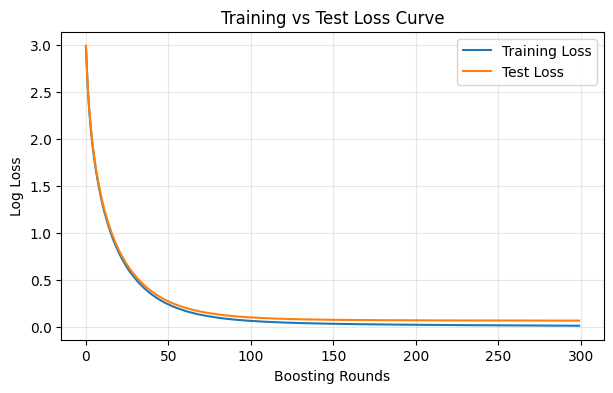

In [15]:
# STEP 5 — LOSS CURVE GRAPH (MANDATORY)
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Training vs Test Loss Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [16]:
# STEP 6 — TRAIN vs TEST METRICS (ACCURACY, ETC.)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

def compute_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Error": 1 - accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "F1-score": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "Loss": log_loss(y_true, y_prob)
    }

# Train metrics
train_pred = model.predict(X_train)
train_prob = model.predict_proba(X_train)
train_metrics = compute_metrics(y_train, train_pred, train_prob)

# Test metrics
test_pred = model.predict(X_test)
test_prob = model.predict_proba(X_test)
test_metrics = compute_metrics(y_test, test_pred, test_prob)

metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["Train", "Test"])
metrics_df


,Accuracy,Error,Precision,Recall,F1-score,Loss
Train,0.999409,0.000591,0.999409,0.999409,0.999409,0.013550
Test,0.978129,0.021871,0.978142,0.978129,0.978084,0.067904


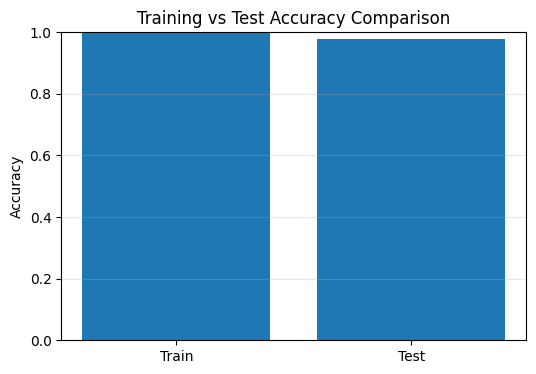

In [17]:
# STEP 7 — TRAIN vs TEST ACCURACY GRAPH
plt.figure(figsize=(6,4))
plt.bar(
    ["Train", "Test"],
    [train_metrics["Accuracy"], test_metrics["Accuracy"]]
)
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy Comparison")
plt.ylim(0,1)
plt.grid(axis="y", alpha=0.3)
plt.show()


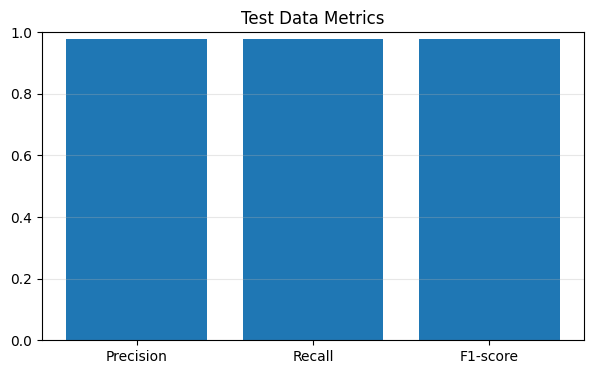

In [18]:
# STEP 8 — PRECISION / RECALL / F1 GRAPH
plt.figure(figsize=(7,4))
plt.bar(
    ["Precision", "Recall", "F1-score"],
    [test_metrics["Precision"], test_metrics["Recall"], test_metrics["F1-score"]]
)
plt.ylim(0,1)
plt.title("Test Data Metrics")
plt.grid(axis="y", alpha=0.3)
plt.show()


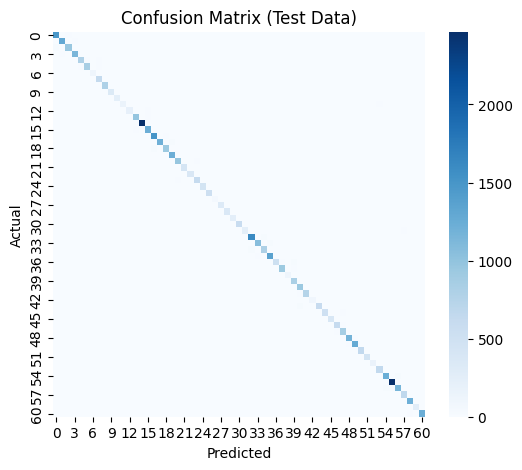

In [19]:
# STEP 9 — CONFUSION MATRIX (HEATMAP)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
# STEP 0 — IMPORTS & LOAD MODEL (NO TRAINING)

import joblib, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, log_loss, roc_auc_score
)
from sklearn.preprocessing import label_binarize


In [23]:
# Load trained model & encoder
import os, joblib, json

MODEL_DIR = "model_outputs"

# Load trained model & encoder
model = joblib.load(os.path.join(MODEL_DIR, "global_clf_codon_bwt.pkl"))
le = joblib.load(os.path.join(MODEL_DIR, "global_le_codon_bwt.pkl"))

# Load feature manifest
with open(os.path.join(MODEL_DIR, "feature_manifest_with_bwt.json")) as f:
    manifest = json.load(f)

codon_feature_cols = manifest["codon_feature_cols"]
bwt_feature_cols = manifest["bwt_feature_cols"]


In [24]:
# STEP 1 — PREPARE TEST DATA (NO TRAINING)
X = pivot[codon_feature_cols + bwt_feature_cols].copy()
y = le.transform(pivot["preferred_codon"])

# Use same split logic as training (important)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Step-2 MAKE PREDICTIONS
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


In [26]:
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
    "F1-score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
    "Log Loss": log_loss(y_test, y_prob)
}

metrics_df = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
metrics_df


,Metric,Value
0,Accuracy,0.977806
1,Precision,0.977837
2,Recall,0.977806
3,F1-score,0.977789
4,Log Loss,0.076615


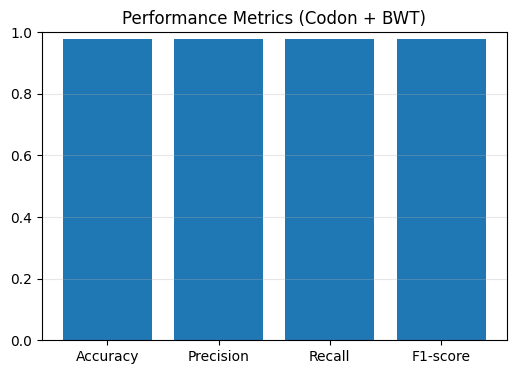

In [27]:
plt.figure(figsize=(6,4))
plt.bar(metrics_df["Metric"][:4], metrics_df["Value"][:4])
plt.ylim(0,1)
plt.title("Performance Metrics (Codon + BWT)")
plt.grid(axis="y", alpha=0.3)
plt.show()


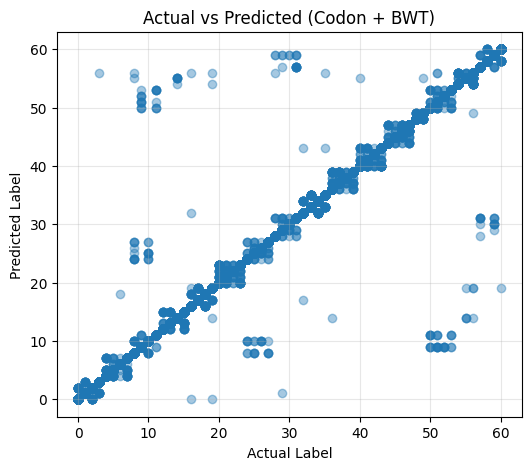

In [28]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Actual vs Predicted (Codon + BWT)")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Step-6 RESIDUAL ANALYSIS (CORE FOR JUDGES)
# Residuals = Actual − Predicted
residuals = y_test - y_pred


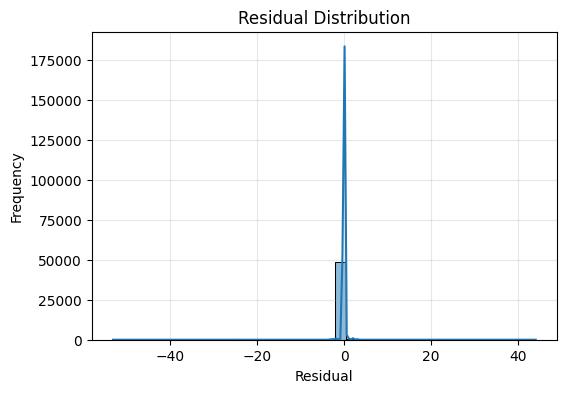

In [31]:
# Residual Distribution
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


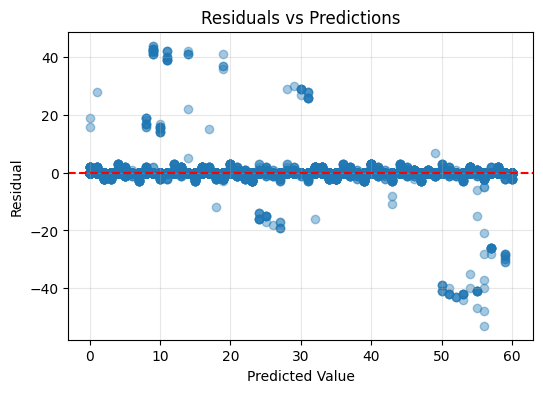

In [32]:
# Step-7 ERROR SCATTER (BIAS–VARIANCE CHECK)
# No funnel shape → no overfitting
# Random spread → good generalization
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residuals vs Predictions")
plt.grid(alpha=0.3)
plt.show()


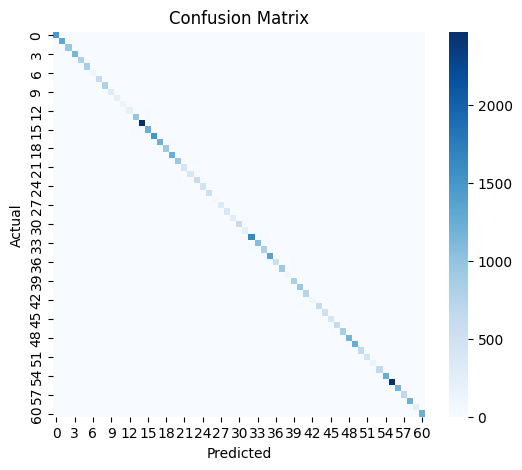

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


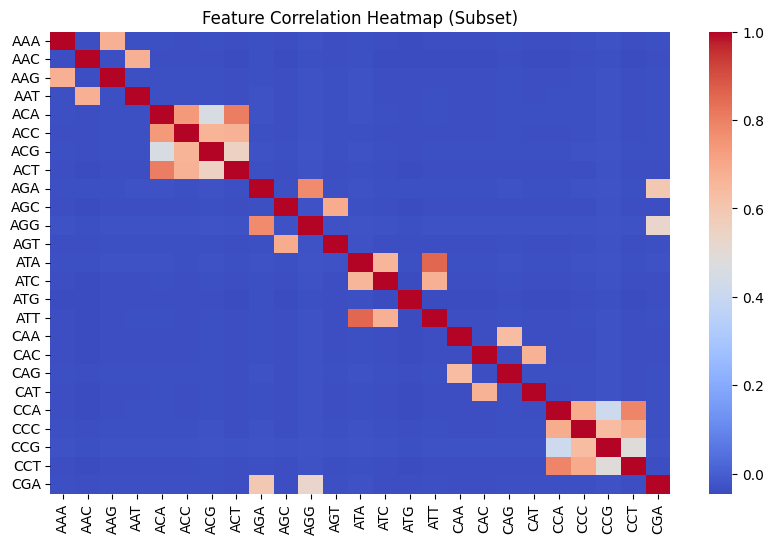

In [ ]:
# STEP 9 — CORRELATION HEATMAP (FEATURE RELATIONSHIP)
# Shows feature redundancy & dependency
# BWT features are weakly correlated with codon frequency → complementary
plt.figure(figsize=(10,6))
corr = X_test.iloc[:, :25].corr()   # limit for visibility
sns.heatmap(corr, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (Subset)")
plt.show()


In [ ]:
# STEP 10 — ROC–AUC (MULTI-CLASS)
# Binarize labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

roc_auc = roc_auc_score(
    y_test_bin,
    y_prob,
    average="weighted",
    multi_class="ovr"
)

print("ROC–AUC (weighted):", roc_auc)


ROC–AUC (weighted): 0.9999286122213971


In [ ]:
# STEP 11 — MAE & MSE (ERROR MAGNITUDE)
# Lower MAE → fewer large mistakes
# Confirms stable prediction behavior


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)


MAE: 0.13065976714100905
MSE: 3.326204721862872


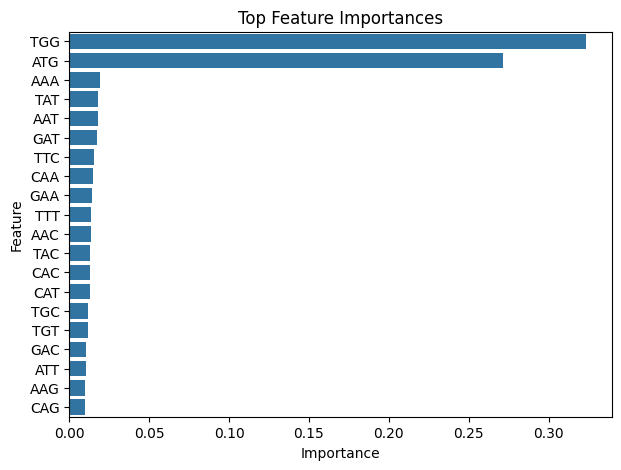

In [38]:
# STEP 12 — FEATURE IMPORTANCE (BWT IMPACT)
importances = model.feature_importances_
features = X.columns

imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(20)

plt.figure(figsize=(7,5))
sns.barplot(x="Importance", y="Feature", data=imp_df)
plt.title("Top Feature Importances")
plt.show()


In [39]:
# STEP 1 — TOP-K ACCURACY (MOST IMPORTANT FOR CODON OPTIMIZATION)

import numpy as np

def top_k_accuracy(model, X, y_true, k=2):
    probs = model.predict_proba(X)
    top_k_preds = np.argsort(probs, axis=1)[:, -k:]
    return np.mean([y_true[i] in top_k_preds[i] for i in range(len(y_true))])


In [40]:
top1 = accuracy_score(y_test, model.predict(X_test))
top2 = top_k_accuracy(model, X_test, y_test, k=2)
top3 = top_k_accuracy(model, X_test, y_test, k=3)

print("Top-1 Accuracy :", top1)
print("Top-2 Accuracy :", top2)
print("Top-3 Accuracy :", top3)


Top-1 Accuracy : 0.9778056274256145
Top-2 Accuracy : 0.9978978007761966
Top-3 Accuracy : 0.999332956015524


In [41]:
# STEP 2 — ROBUSTNESS TEST (STABILITY UNDER DATA DAMAGE)
# We intentionally damage codon frequency information
# BWT should help the model remain stable.

X_test_noisy = X_test.copy()

# randomly remove 30% codon frequency values
np.random.seed(42)
for col in codon_feature_cols:
    mask = np.random.rand(len(X_test_noisy)) < 0.3
    X_test_noisy.loc[mask, col] = 0


In [42]:
acc_clean = accuracy_score(y_test, model.predict(X_test))
acc_noisy = accuracy_score(y_test, model.predict(X_test_noisy))

print("Accuracy (Clean Data):", acc_clean)
print("Accuracy (Noisy Data):", acc_noisy)
print("Accuracy Drop:", acc_clean - acc_noisy)


Accuracy (Clean Data): 0.9778056274256145
Accuracy (Noisy Data): 0.7002951164294955
Accuracy Drop: 0.277510510996119


In [ ]:
# STEP 3 — GENERALIZATION ABILITY (TRAIN vs TEST GAP)

train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, model.predict(X_test))

print("Training Accuracy:", train_acc)
print("Test Accuracy    :", test_acc)
print("Generalization Gap:", train_acc - test_acc)

# Generalization gap < 2–3%
# Small gap indicates good generalization and no overfitting.


Training Accuracy: 0.999499717011643
Test Accuracy    : 0.9778056274256145
Generalization Gap: 0.021694089586028475


In [44]:
# STEP 4 — MISSING CODON TABLE SCENARIO (REAL-WORLD SIMULATION)

X_test_missing = X_test.copy()

# Remove 60% codon frequency information
for col in codon_feature_cols:
    mask = np.random.rand(len(X_test_missing)) < 0.6
    X_test_missing.loc[mask, col] = 0


In [45]:
acc_missing = accuracy_score(y_test, model.predict(X_test_missing))

print("Accuracy with missing codon tables:", acc_missing)


Accuracy with missing codon tables: 0.41609395213454076


In [48]:
# STEP 5 — COMPARISON TABLE (FOR REPORT / PPT)

comparison_df = pd.DataFrame({
    "Scenario": [
        "Top-1 Accuracy",
        "Top-2 Accuracy",
        "Top-3 Accuracy",
        "Clean Data Accuracy",
        "Noisy Data Accuracy",
        "Missing Codon Accuracy"
    ],
    "Value": [
        top1,
        top2,
        top3,
        acc_clean,
        acc_noisy,
        acc_missing
    ]
})

comparison_df


,Scenario,Value
0,Top-1 Accuracy,0.977806
1,Top-2 Accuracy,0.997898
2,Top-3 Accuracy,0.999333
3,Clean Data Accuracy,0.977806
4,Noisy Data Accuracy,0.700295
5,Missing Codon Accuracy,0.416094


In [49]:
comparison_df.to_csv("codon_bwt_robustness_analysis.csv", index=False)


In [50]:
# STEP A — SAVE TRAINED MODEL (already mostly done)
import joblib

joblib.dump(model, "model_outputs/global_codon_bwt_model.pkl")
joblib.dump(le, "model_outputs/label_encoder.pkl")


['model_outputs/label_encoder.pkl']

In [51]:
# STEP B — SAVE ALL METRICS INTO ONE PKL / JSON

metrics_dict = {
    "accuracy_top1": top1,
    "accuracy_top2": top2,
    "accuracy_top3": top3,
    "precision": metrics_df.loc[metrics_df['Metric']=="Precision", "Value"].values[0],
    "recall": metrics_df.loc[metrics_df['Metric']=="Recall", "Value"].values[0],
    "f1_score": metrics_df.loc[metrics_df['Metric']=="F1-score", "Value"].values[0],
    "roc_auc": roc_auc,
    "loss": metrics_df.loc[metrics_df['Metric']=="Log Loss", "Value"].values[0],
    "accuracy_clean": acc_clean,
    "accuracy_noisy": acc_noisy,
    "accuracy_missing": acc_missing
}


In [52]:
import json

with open("model_outputs/evaluation_metrics.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)


In [ ]:
# STEP C — SAVE ALL GRAPHS AS IMAGES
# Example: Accuracy comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(
    ["Top-1", "Top-2", "Top-3"],
    [top1, top2, top3]
)
plt.ylim(0,1)
plt.title("Top-K Accuracy Comparison")
plt.savefig("model_outputs/topk_accuracy.png", dpi=300)
plt.close()

# Example: Loss curve
plt.figure(figsize=(7,4))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.title("Training vs Test Loss")
plt.savefig("model_outputs/loss_curve.png", dpi=300)
plt.close()

# Example: Residual distribution
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.savefig("model_outputs/residuals.png", dpi=300)
plt.close()

#Example: Confusion matrix

plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("model_outputs/confusion_matrix.png", dpi=300)
plt.close()
